In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
DATA_DIR = '../../data/raw'

In [3]:
gc.enable() # включение garbage collector

train = pd.read_csv(os.path.join(DATA_DIR, 'training_set.csv')) # считывание тренировочных данных (кривые)
train.shape

(1421705, 6)

In [4]:
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']
train.shape

(1421705, 8)

In [5]:
aggs = {
    'mjd': ['min', 'max', 'size'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

In [6]:
agg_train = train.groupby(['object_id', 'passband']).agg(aggs)
agg_train.shape

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-1718abc9fc32>", line 1, in <module>
    agg_train = train.groupby(['object_id', 'passband']).agg(aggs)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py", line 4658, in aggregate
    return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py", line 4089, in aggregate
    result, how = self._aggregate(arg, _level=_level, *args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/base.py", line 490, in _aggregate
    result = _agg(arg, _agg_1dim)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/base.py", line 441, in _agg
    result[fname] = func(fname, agg_how)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/base.py", li

KeyboardInterrupt: 

In [ ]:
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns

In [ ]:
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del train
gc.collect() # сбор мусора

# convert from multindex df to single index
agg_train = agg_train.reset_index(level=[0,1])


In [ ]:
features = agg_train.columns.drop(['passband', 'object_id'])

agg_train = agg_train.groupby('object_id')[features].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()


In [ ]:
agg_train.head()

In [ ]:
new_columns = []

for feat in features:
    for i in range(0, 6):
        new_columns.append(feat + "_pb" + str(i))
        
new_columns = ['object_id'] + new_columns

In [ ]:
len(new_columns)

In [ ]:
agg_train.columns = new_columns
agg_train.head()

In [ ]:
meta_train = pd.read_csv(os.path.join(DATA_DIR, 'training_set_metadata.csv')) # считывание тренировочных данных (метадата)

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
# определение веса каждого класса
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

In [ ]:
meta_train.head()

In [ ]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz'] # удаление колонок
    del full_train['ra'], full_train['decl'], full_train['gal_l'], full_train['gal_b'], full_train['ddf'] # удаление колонок
    

# заполнение NaN
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # деление данных на фолды для кросс-валидации

In [ ]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

## Построение модели

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

### Определение функции ошибки

In [ ]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


In [ ]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [ ]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
    
print(unique_y)
print()
print(class_map)
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
print(y_map)
y_categorical = to_categorical(y_map)


In [ ]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]


In [ ]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()


In [ ]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 250
batch_size = 100
checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.6,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=2,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))


In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [27]:
sample_sub = pd.read_csv('../../data/raw/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()


52449

Normalized confusion matrix
[[9.07e-01 0.00e+00 1.32e-02 0.00e+00 0.00e+00 6.62e-03 0.00e+00 0.00e+00
  5.96e-02 0.00e+00 0.00e+00 0.00e+00 1.32e-02 0.00e+00]
 [2.02e-03 7.70e-01 0.00e+00 1.41e-02 1.82e-02 0.00e+00 6.46e-02 1.82e-02
  6.06e-03 4.24e-02 8.08e-03 4.85e-02 0.00e+00 8.08e-03]
 [1.08e-03 0.00e+00 9.90e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  3.25e-03 0.00e+00 0.00e+00 0.00e+00 5.41e-03 0.00e+00]
 [3.35e-03 1.27e-01 1.68e-03 1.66e-01 1.48e-01 8.38e-04 1.41e-01 3.60e-02
  5.03e-03 1.42e-01 2.51e-03 1.68e-01 0.00e+00 5.70e-02]
 [0.00e+00 2.19e-02 0.00e+00 5.46e-02 3.66e-01 0.00e+00 8.74e-02 5.46e-03
  5.46e-03 1.58e-01 0.00e+00 2.73e-01 0.00e+00 2.73e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [2.27e-02 3.10e-02 0.00e+00 6.82e-02 1.01e-01 0.00e+00 2.79e-01 6.20e-02
  6.20e-03 2.89e-01 0.00e+00 1.10e-01 0.00e+00 3.10e-02]
 [0.00e+00 9.80e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00

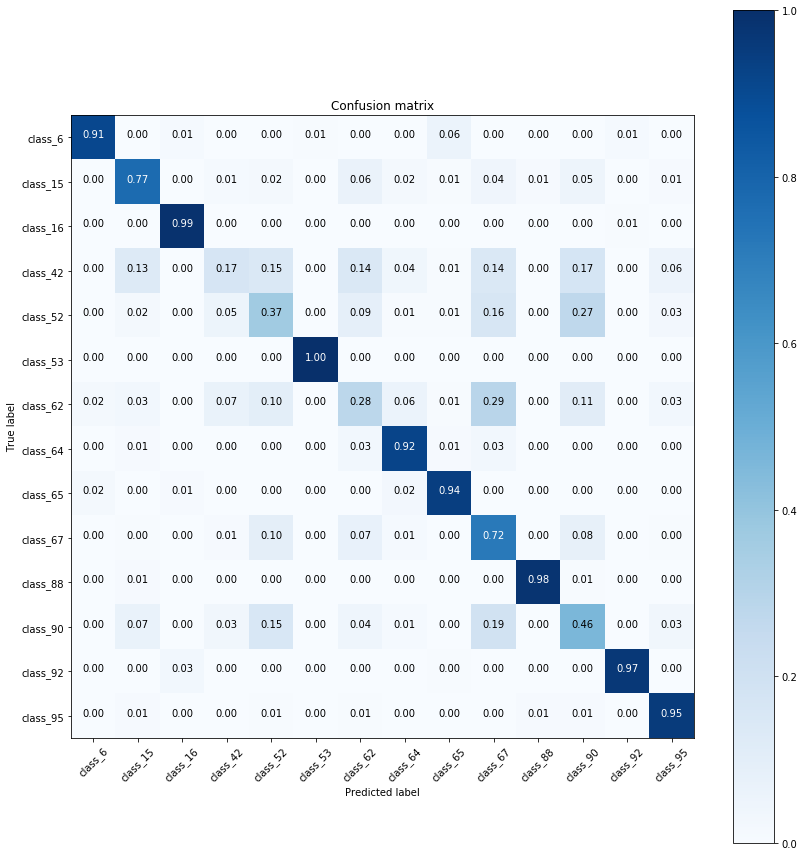

In [28]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [ ]:
meta_test = pd.read_csv('../../data/raw/test_set_metadata.csv') # считывание тестовых данных (кривые)

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../../data/raw/test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    aggs = {
        'mjd': ['min', 'max', 'size'],
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew'],
    }
    agg_test = df.groupby(['object_id', 'passband']).agg(aggs)
    print(agg_test.shape)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    
    
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    agg_test = agg_test.reset_index(level=[0,1])
    
    del df
    gc.collect()
    
    features = agg_test.columns.drop(['passband', 'object_id'])

    agg_test = agg_test.groupby('object_id')[features].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
    
    new_columns = []

    for feat in features:
        for i in range(0, 6):
            new_columns.append(feat + "_pb" + str(i))

    new_columns = ['object_id'] + new_columns
    
    agg_test.columns = new_columns
    agg_test.head()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('../../data/submissions/predictions2.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('../../data/submissions/predictions2.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

(90828, 20)
(91104, 20)
(209789, 20)
(234348, 20)
(234290, 20)
(234474, 20)
(234336, 20)
(234558, 20)
(234480, 20)
(234330, 20)
       50000000 done in  28.1
(234580, 20)
(234354, 20)
(234594, 20)
(234580, 20)
(234526, 20)
(234330, 20)
(234204, 20)
(234574, 20)
(234666, 20)
(234474, 20)
      100000000 done in  59.2
(234216, 20)
(234124, 20)
(234619, 20)
(234330, 20)
(234510, 20)
(234567, 20)
(234294, 20)
(234522, 20)
(234576, 20)
(234504, 20)
      150000000 done in  91.5
(234510, 20)
(234354, 20)
(234486, 20)
(234438, 20)
(234444, 20)
(234570, 20)
(234642, 20)
(234328, 20)
(234421, 20)
(234252, 20)
      200000000 done in 125.3
(234593, 20)
(234282, 20)
(234136, 20)
(234012, 20)
(234165, 20)
(234216, 20)
(234420, 20)
(234384, 20)
(234546, 20)
(234480, 20)
      250000000 done in 161.4
(234480, 20)
(234462, 20)
(234510, 20)
(234227, 20)
(234330, 20)
(234474, 20)
(234516, 20)


In [22]:
z = pd.read_csv('../data/submissions/predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('../data/submissions/single_predictions.csv', index=True)

2
88


In [23]:
z.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,2.092491e-05,0.009581,1.891352e-05,0.385556,0.212884,2.074104e-07,0.290095,0.000043,0.000047,0.018884,0.000143,0.082653,4.536868e-07,0.000073,0.155924
14,1.820848e-06,0.006375,3.255423e-06,0.073684,0.227542,4.575380e-07,0.036590,0.000161,0.000108,0.127537,0.004492,0.522556,5.182726e-06,0.000944,0.144584
17,9.550799e-07,0.009783,2.365789e-05,0.099976,0.126518,1.102058e-07,0.036680,0.000122,0.000038,0.053049,0.075860,0.591713,3.557892e-05,0.006200,0.135679
23,5.353507e-07,0.007583,4.471621e-07,0.108888,0.179659,8.533474e-07,0.067515,0.000139,0.000023,0.132494,0.000566,0.499702,7.258828e-07,0.003428,0.149013
34,8.966589e-06,0.010537,3.113280e-08,0.104071,0.130250,2.743362e-07,0.087482,0.000129,0.000060,0.182233,0.000092,0.475869,3.952643e-07,0.009267,0.152222
